<a href="https://colab.research.google.com/github/enviroCar/notebooks/blob/main/enviroCar_track_acceleration_values_animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
!pip install geopandas pandas

# set an output directory for the animation and chart:
root_dir = '/content/'

%load_ext autoreload
%autoreload 2

# load dependencies
import pandas as pd
import geopandas as gpd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
# import datetime to help define sample period:
import datetime as dt
# import pandas for data wrangling:
import pandas as pd
# import matplotlib, pyplot and animation for plotting and animating:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import requests

# define the animation embed limit for matplotlib:
matplotlib.rcParams['animation.embed_limit'] = 200**128

In [83]:
track_id = "61ba1e747b277d59bd0e4894"



In [84]:
track_url = "https://envirocar.org/api/stable/tracks/%s" % track_id
response = requests.get(track_url)
track_json = response.json()

response = requests.get("https://envirocar.org/api/stable/phenomenons")
phen_json = response.json()

phen_list = list(map(lambda p: p["name"], phen_json["phenomenons"]))

#track_filter_start = track_json["properties"]["begin"]
#track_filter_end = track_json["properties"]["end"]
track_filter_start = '2021-12-12T10:36:19Z'
track_filter_end = '2021-12-12T12:42:51Z'

phen_list

['CO2',
 'Calculated MAF',
 'Consumption',
 'Engine Load',
 'Fuel System Loop',
 'Fuel System Status Code',
 'GPS Accuracy',
 'GPS Altitude',
 'GPS Bearing',
 'GPS HDOP',
 'GPS PDOP',
 'GPS Speed',
 'GPS VDOP',
 'Intake Pressure',
 'Intake Temperature',
 'Long-Term Fuel Trim 1',
 'MAF',
 'O2 Lambda Current',
 'O2 Lambda Current ER',
 'O2 Lambda Voltage',
 'O2 Lambda Voltage ER',
 'Rpm',
 'Short-Term Fuel Trim 1',
 'Speed',
 'Throttle Position',
 'CO2 Emission (GPS-based)',
 'Consumption (GPS-based)',
 'Energy Consumption',
 'Minimum Acceleration',
 'Maximum Acceleration',
 'Maximum GPS Acceleration',
 'Minimum GPS Acceleration']

In [85]:
time_list = list(map(lambda f: f["properties"]["time"], track_json["features"]))

phen_parsed = {
    'time': time_list
}

for p in phen_list:

  parsed = list(map(lambda f: f["properties"]["phenomenons"][p]["value"] if p in f["properties"]["phenomenons"] else None, track_json["features"]))
  if (sum(x != None for x in parsed) > 0):
    phen_parsed["%s.value" % p] = parsed
  else:
    print("no values for: %s" % p)

track_df = pd.DataFrame(phen_parsed)
track_df

no values for: CO2
no values for: Calculated MAF
no values for: Consumption
no values for: Engine Load
no values for: Fuel System Loop
no values for: Fuel System Status Code
no values for: Intake Pressure
no values for: Intake Temperature
no values for: Long-Term Fuel Trim 1
no values for: MAF
no values for: O2 Lambda Current
no values for: O2 Lambda Current ER
no values for: O2 Lambda Voltage
no values for: O2 Lambda Voltage ER
no values for: Rpm
no values for: Short-Term Fuel Trim 1
no values for: Throttle Position
no values for: CO2 Emission (GPS-based)
no values for: Consumption (GPS-based)
no values for: Energy Consumption


,time,GPS Accuracy.value,GPS Altitude.value,GPS Bearing.value,GPS HDOP.value,GPS PDOP.value,GPS Speed.value,GPS VDOP.value,Speed.value,Minimum Acceleration.value,Maximum Acceleration.value,Maximum GPS Acceleration.value,Minimum GPS Acceleration.value
0,2021-12-15T16:17:08Z,8.850437,117.834174,162.468073,0.900000,1.200000,1.531538,0.800000,0.000000,-0.690989,0.685871,0.580138,-0.512563
1,2021-12-15T16:17:18Z,9.101999,112.000003,170.454429,1.169910,1.469910,0.000000,0.800000,1.429942,0.000000,0.662954,0.599593,-0.303030
2,2021-12-15T16:17:23Z,6.068000,107.000002,349.299988,1.200000,1.500000,0.000000,0.800000,0.272727,-0.680828,0.701459,0.000000,-0.365252
3,2021-12-15T16:17:28Z,6.068000,103.999998,350.899994,0.900000,1.200000,0.113448,0.800000,1.000000,0.000000,0.725268,0.267062,-0.270000
4,2021-12-15T16:17:34Z,6.068000,104.000002,338.559631,1.056699,1.356699,1.320983,0.814175,1.000000,-0.679163,0.672585,0.374753,-0.084034
5,2021-12-15T16:17:39Z,7.585000,102.713330,317.955984,0.969565,1.269565,2.047680,0.800000,2.000000,0.000000,0.723380,0.263158,0.010395
6,2021-12-15T16:17:44Z,7.585000,102.541048,322.136205,1.060373,1.360373,9.900676,0.800000,11.000000,-0.631313,1.446759,0.795918,0.000000
7,2021-12-15T16:17:49Z,6.068000,104.353535,322.690917,0.840331,1.140331,12.242909,0.800000,12.000000,-0.697934,0.000000,-0.316004,-0.410156
8,2021-12-15T16:17:54Z,4.551000,105.000000,325.694983,0.800000,1.100000,6.625447,0.800000,6.000000,-0.674218,0.659805,0.385005,-0.120603
9,2021-12-15T16:17:59Z,4.551000,104.890492,41.204899,0.700000,1.000000,14.067804,0.714732,17.884793,-0.659805,2.099076,1.578401,0.634006


In [86]:
phenomena = ["Minimum Acceleration.value", "Maximum Acceleration.value"]
#phenomena = ["Speed.value"]

In [87]:
import datetime
from dateutil import parser
df = track_df

# parse the time and use as index
df['time_index'] = pd.to_datetime(df['time'])
df = df.set_index('time_index')

# only select phenomena of interest
df = df[[*phenomena, 'time']].pad()

# resample to 1 second for better animation
df = df.resample('s').fillna("ffill")

#df = df.head(40)

df

,Minimum Acceleration.value,Maximum Acceleration.value,time
time_index,,,
2021-12-15 16:17:08+00:00,-0.690989,0.685871,2021-12-15T16:17:08Z
2021-12-15 16:17:09+00:00,-0.690989,0.685871,2021-12-15T16:17:08Z
2021-12-15 16:17:10+00:00,-0.690989,0.685871,2021-12-15T16:17:08Z
2021-12-15 16:17:11+00:00,-0.690989,0.685871,2021-12-15T16:17:08Z
2021-12-15 16:17:12+00:00,-0.690989,0.685871,2021-12-15T16:17:08Z
...,...,...,...
2021-12-15 16:20:43+00:00,-1.876877,0.000000,2021-12-15T16:20:42Z
2021-12-15 16:20:44+00:00,-1.876877,0.000000,2021-12-15T16:20:42Z
2021-12-15 16:20:45+00:00,-1.876877,0.000000,2021-12-15T16:20:42Z


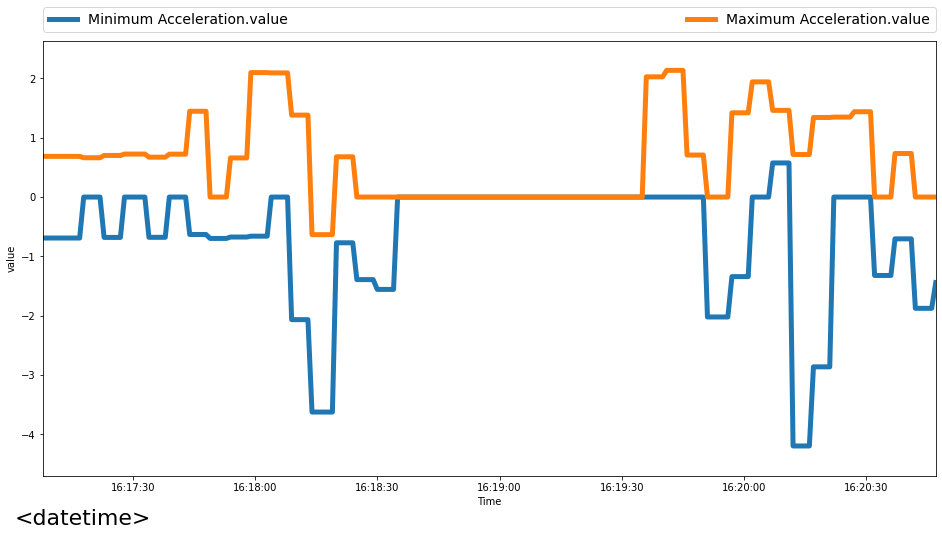

In [88]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

# bounds
ax.set_xlim(df.index[0],df.index[-1])

# min in phenomena
ymin = 0
ymax = 0
for p in phenomena:
  ymin = min(ymin, df[p].min()-0.5)
  ymax = max(ymax, df[p].max()+0.5)

ax.set_ylim(ymin, ymax)

lines = []
for p in phenomena:
  new_line, = ax.plot(df[p], data= df, marker='', linewidth=5)
  lines.append(new_line)

# set the x-axis label:
plt.xlabel('Time',fontsize=10)

# set the y-axis label:
plt.ylabel('value',fontsize=10)

# add a legend to the plot:
#plt.legend()
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncol=2, mode="expand", borderaxespad=0., prop={"size":14})

text = fig.text(0.10, 0.05, "<datetime>",
        horizontalalignment='left',
        verticalalignment='center', fontsize=22, color='black')

# show the chart:
plt.show();

In [89]:
def init_animation():
    for l in lines:
        l.set_data([], [])

    return lines


In [90]:
# define the function animate, which has the input argument of i:
def animate(i):
    # update the current timestamp
    text.set_text(df["time"].iloc[i])

    # select data up to current index and previous 20 frames
    data =  df.iloc[max(0, int(i-60)):int(i+1)]

    ax.set_xlim(data.index[0],data.index[-1])
    #   initialise xp as an empty list:
    xp = data.index

    i = 0
    for l in lines:
      y1 = data[phenomena[i]]
      l.set_data(xp, y1)
      i = i+1
        
    return lines
  

In [91]:
# calculate fps
# import dateutil
# total_mesaurements = len(df)
# print(total_mesaurements)
# s = df['time'].iat[0]
# e = df['time'].iat[-1]
# length_s = e-s
# fps = length_s.seconds / total_mesaurements
fps = 1
fps

1

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')
# call Matplotlib animation.Funcanimation, providing the input arguments of fig, animate, the number of frames and an interval:
interval_ms = int(fps * 1000)
ani = animation.FuncAnimation(fig, animate, init_func=init_animation, frames = len(df), interval=interval_ms)
ani



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Attempting to set identical left == right == 738139.6785648149 results in singular transformations; automatically expanding.
  if __name__ == '__main__':


In [ ]:
# Use the 'ffmpeg' writer:
Writer = animation.writers['ffmpeg']

# Set the frames per second and bitrate of the video:
writer = Writer(fps=1/interval_ms*1000, metadata=dict(artist='Me'), bitrate=1800)
# save the animation to the predefined output directory:
ani.save(root_dir +'%s_animation_video_ffill.mp4' % track_id, writer=writer)